# Lab 2.

## 2. a)

In [1]:
import random
#trajektoria to oczywiście funkcja czasu będziemy, więc zwracali funkcję
def generate_pois_trajectory(l=1, domain_upper_limit=1000):
    jump_times = []
    while(True):
        interval = random.expovariate(l)
        if not jump_times:
            jump_times.append(interval)
        else:
            if jump_times[-1] + interval < domain_upper_limit:
                jump_times.append(interval + jump_times[-1])
            else:
                break
    def trajectory(x):
        if x<0 or x>=domain_upper_limit:
            return 0
        jumps_occured = 0
        while(jump_times[jumps_occured] < x):
            jumps_occured += 1
        return jumps_occured
    return trajectory
    

Text(0.5, 1.0, 'Poisson process with intensity l=5 trajectory')

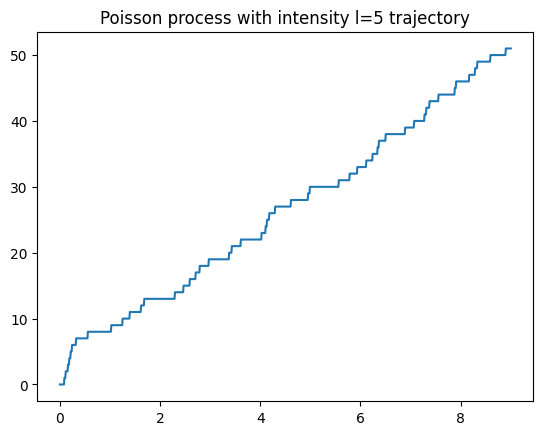

In [2]:
import matplotlib.pyplot as plt
import numpy as np
l=5
pois_trajectory = generate_pois_trajectory(l, 10)
pois_trajectory_vectorised = np.vectorize(pois_trajectory)
x = np.linspace(0, 9, 1000)
y = pois_trajectory_vectorised(x)
plt.plot(x,y)
plt.title(f"Poisson process with intensity l={l} trajectory")

## 2. b)

### 1. Metoda (chyba) bardziej intuicyjna 

In [3]:
import math
#tutaj już zwrócimy zwykłego arraya bo sami ustalamy, gdzie chcemy znać wartości
def generate_wiener_trajectory1(T=100, npoints = 1000):
    dt = T/(npoints - 1)
    sigma = math.sqrt(dt)
    increments = np.random.normal(0, sigma, npoints-1)
    increments = np.insert(increments, 0, 0.0)
    trajectory = np.cumsum(increments)
    times = np.linspace(0, T, npoints)
    trajectory = np.vstack((times, trajectory))
    return trajectory
    
    

Text(0.5, 1.0, 'Standard Wiener process')

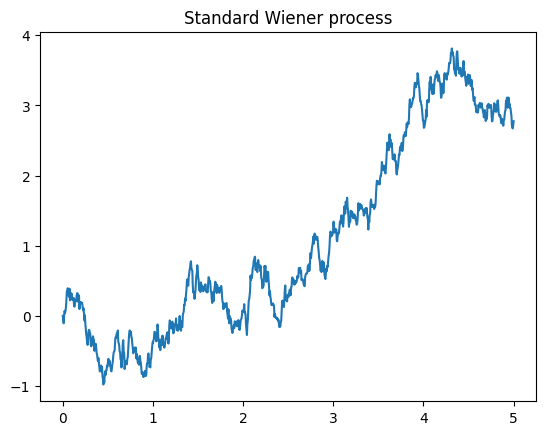

In [5]:
trajectory = generate_wiener_trajectory1(5)
x = trajectory[0]
y = trajectory[1]
plt.plot(x,y)
plt.title("Standard Wiener process")

### 2. Metoda (chyba) mniej intuicyjna

In [7]:
def cholesky(S): #S - macierz kwadratowa dodatnio okreslona
    n = len(S)
    L = [[0.0] * n for i in range(n)]
    for i in range(n):
        for k in range(i+1):
            tmp_sum = sum(L[i][j] * L[k][j] for j in range(k))
            if (i == k):
                L[i][k] = math.sqrt(S[i][i] - tmp_sum)
            else:
                L[i][k] = (1.0 / L[k][k] * (S[i][k] - tmp_sum))
    return np.array(L)

def generate_wiener_trajectory2(T=100, npoints=1000):
    times = np.linspace(0,T,npoints)
    sigma = np.zeros((npoints-1, npoints-1), dtype=float)
    for i in range(npoints-1):
        time = times[i+1]
        for j in range(i, npoints-1):
            sigma[i][j] = time
            sigma[j][i] = time
    A = cholesky(sigma)
    normal_vector = np.random.normal(0,1, npoints-1)
    values = np.dot(A, normal_vector)
    values = np.insert(values, 0 , 0.0)
    trajectory = np.vstack((times, values))
    return trajectory
    
        

Text(0.5, 1.0, 'Standard Wiener process')

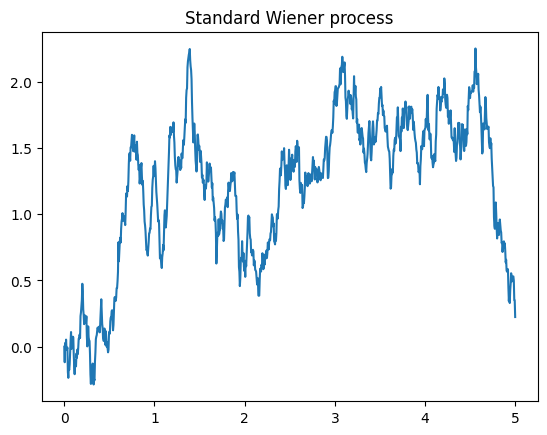

In [6]:
trajectory = generate_wiener_trajectory2(5)
x = trajectory[0]
y = trajectory[1]
plt.plot(x,y)
plt.title("Standard Wiener process")

### porównanie prędkości

In [123]:
import time
start_time = time.time()
for i in range(100):
    generate_wiener_trajectory1()
end_time = time.time()
avg = (end_time-start_time)/100
print(f"Average execution time for first method {avg}")

start_time = time.time()
for i in range(100):
    generate_wiener_trajectory2()
end_time = time.time()
avg = (end_time-start_time)/100
print(f"Average execution time for second method {avg}")
#ta pierwsza nieco szybsza

Average execution time for first method 3.7531852722167966e-05
Average execution time for second method 16.860368013381958


## 2. c)

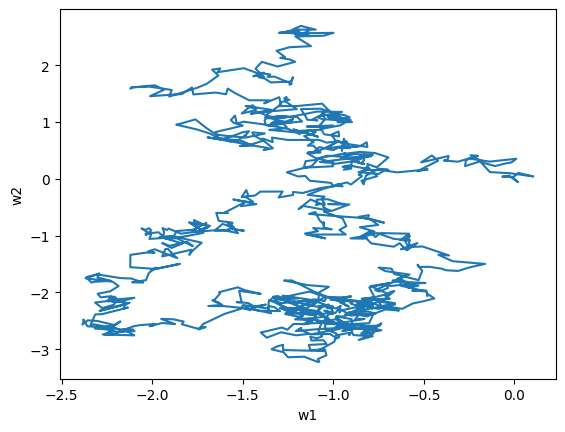

In [10]:
w1 = generate_wiener_trajectory1(5)
w2 = generate_wiener_trajectory1(5)
y1 = w1[1]
y2 = w2[1]
t = w1[0]
#trajektoria bez osi czasu
plt.plot(y1,y2)
plt.xlabel('w1')
plt.ylabel('w2')
plt.show()



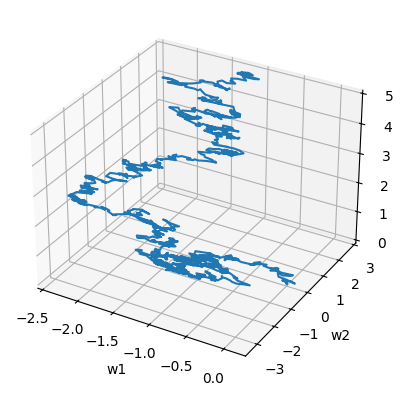

In [11]:
#trajektoria z osią czasu
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(y1, y2, t)
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('t')
plt.show()

## 2. d)

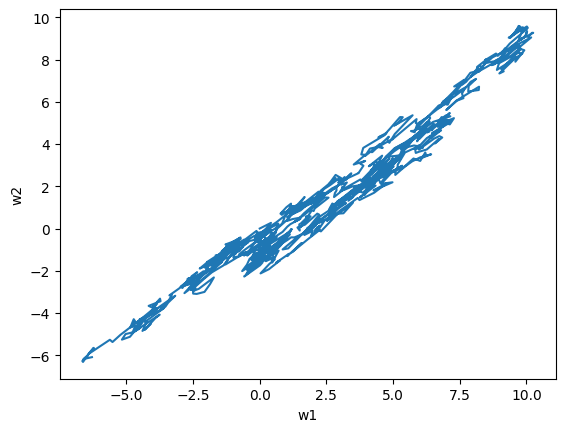

In [18]:
#pierwsza kropa
def generate_correlated_wieners(rho, T=100, npoints=1000):
    trajectory1 = generate_wiener_trajectory1(T, npoints)
    trajectory2 = generate_wiener_trajectory1(T, npoints)
    for i in range(npoints):
        trajectory2[1][i] = rho*trajectory1[1][i] + np.sqrt((1-rho**2)) * trajectory2[1][i]
    return trajectory1, trajectory2

tra1, tra2 = generate_correlated_wieners(0.9)
w1 = tra1[1]
w2 = tra2[1]
plt.plot(w1,w2)
plt.xlabel('w1')
plt.ylabel('w2')
plt.show()
#jakąś korelację widać

In [9]:
##druga kropa wyjaśniona przez prowadzącego na tablicy w 213
##trzecia kropa
def generate_many_correlated_wieners(rho, T=100, npoints=1000):
    dtsqrt = np.sqrt(T/npoints)
    nwieners = len(rho)
    times = np.linspace(0,T,npoints)
    #czas na osi poziomej wienery na pionowej
    trajectories = np.zeros((nwieners, 1), dtype = float)
    A = cholesky(rho)
    for time in times:
        #pierwsze już mamy
        if time != 0:
            normal_vector = np.random.normal(0,1, nwieners)
            step = dtsqrt*np.dot(A, normal_vector)
            prev_state = trajectories[:,-1]
            curr_state = prev_state + step
            curr_state = curr_state[:,np.newaxis]
            trajectories = np.hstack((trajectories, curr_state))

    return trajectories

In [15]:
A = np.random.normal(0,1, (10,10))
pos_def = np.dot(A, A.T)
traj = generate_many_correlated_wieners(pos_def)
#taka se o macierz
print(traj[:,:5])

[[ 0.          0.23482526  2.00426869  3.60486382  3.42171171]
 [ 0.         -0.2076468   1.11271108  1.39120475  1.5343024 ]
 [ 0.          1.15431883  0.83200695  2.06997738  2.2722838 ]
 [ 0.         -0.79856726 -0.61852999  0.26014472  1.08255034]
 [ 0.         -1.04582174 -1.23552193 -1.4044766  -0.49353763]
 [ 0.         -0.9912322  -1.18570643 -0.42881207 -0.25215099]
 [ 0.          0.25059768  0.27484063  0.65008695  2.13908536]
 [ 0.          0.44590815  1.46205182  1.24222942  0.06120366]
 [ 0.         -0.09067569  0.85691547  0.58596257  0.83919021]
 [ 0.          1.30589628  3.16886948  2.69796219  2.28375482]]


## 2. e)

### MPWL

In [28]:
def generate_from_3point1(n):
    thresh1  = 1/(n+1)**(3/2)
    thresh2 = 1/2
    x = np.random.uniform(0,1)
    y = np.random.uniform(0,1)
    unsigned = n if x < thresh1 else 0
    signed = unsigned if y < thresh2 else -unsigned
    return signed



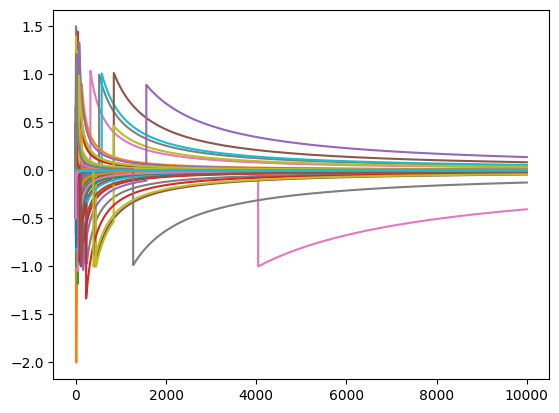

In [32]:

sample_size = 10000
x = np.array([i for i in range(sample_size)])
for i in range(100):
    sample = [generate_from_3point1(j) for j in range(sample_size)]
    cum_avg = np.cumsum(sample)/np.arange(1, sample_size+1)
    plt.plot(x, cum_avg)
#порядок

### SPWL

In [33]:
def generate_from_3point2(n):
    thresh1 = 1/(n+1)*math.log(n+1)
    thresh2 = 1/2
    x = np.random.uniform(0,1)
    y = np.random.uniform(0,1)
    unsigned = n if x < thresh1 else 0
    signed = unsigned if y < thresh2 else -unsigned
    return signed

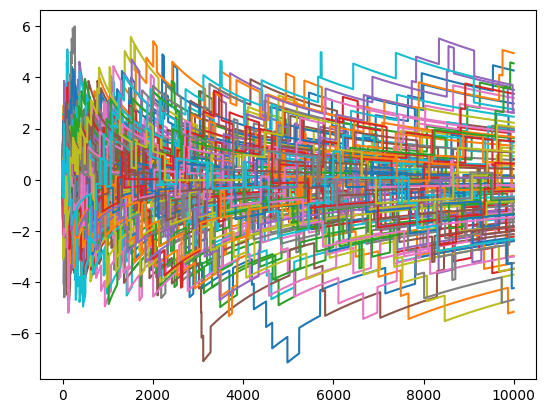

In [35]:
sample_size = 10000
x = np.array([i for i in range(sample_size)])
for i in range(100):
    sample = [generate_from_3point2(j) for j in range(sample_size)]
    cum_avg = np.cumsum(sample)/np.arange(1, sample_size+1)
    plt.plot(x, cum_avg)
#бардак

### Żadne prawo liczb, o których wielkości niespecjalnie wiele wiemy

In [39]:
def generate_from_3point3(n):
    thresh1 = 1/(n+1)
    thresh2 = 1/2
    x = np.random.uniform(0,1)
    y = np.random.uniform(0,1)
    unsigned = n if x < thresh1 else 0
    signed = unsigned if y < thresh2 else -unsigned
    return signed

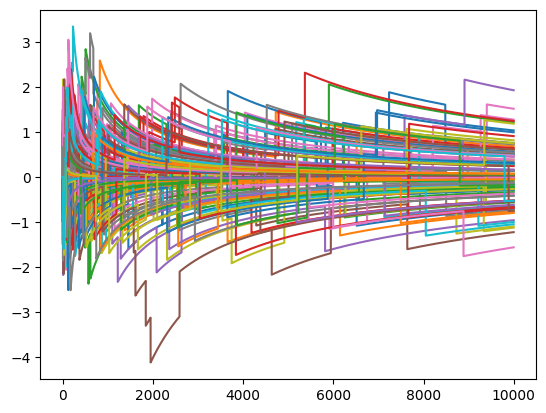

In [40]:
sample_size = 10000
x = np.array([i for i in range(sample_size)])
for i in range(100):
    sample = [generate_from_3point3(j) for j in range(sample_size)]
    cum_avg = np.cumsum(sample)/np.arange(1, sample_size+1)
    plt.plot(x, cum_avg)
#SPWL w sumie wygląda gorzej

## 2. f)

/tmp/ipykernel_10078/1346633146.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(2*x*np.log(np.log(x)))
/tmp/ipykernel_10078/1346633146.py:2: RuntimeWarning: invalid value encountered in log
  return np.sqrt(2*x*np.log(np.log(x)))
/tmp/ipykernel_10078/1346633146.py:2: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2*x*np.log(np.log(x)))


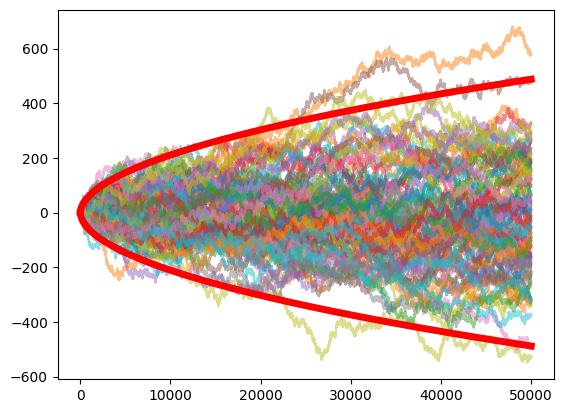

In [4]:
def iterated_log(x):
    return np.sqrt(2*x*np.log(np.log(x)))
trajectories = [generate_wiener_trajectory1(50000, 100000) for i in range(100)]
time = trajectories[0][0]
for trajectory in trajectories:
    plt.plot(time, trajectory[1], alpha=0.5)
iter_log = iterated_log(time)
plt.plot(time, iter_log, color='red', lw=5)
plt.plot(time, -iter_log, color='red', lw=5)
plt.show()
#większość rzeczywiście nie wychodzi poza linie

In [20]:
print(np.zeros((4,1)))

[[0.]
 [0.]
 [0.]
 [0.]]
